# Woring Time Series Data

In [1]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install polars

In [4]:
df = pd.read_csv('../Datasets/time_series_data/train_data.zip')
df.shape

(578, 2)

In [5]:
df.head()

,Date,count
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2


In [6]:
df.dtypes

Date     object
count     int64
dtype: object

In [8]:
df.Date = pd.to_datetime(df.Date)
df.dtypes

Date     datetime64[ns]
count             int64
dtype: object

In [19]:
pd.date_range(start='2018-01-01', periods=5, freq='1D1H1MIN10S')

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-02 01:01:10',
               '2018-01-03 02:02:20', '2018-01-04 03:03:30',
               '2018-01-05 04:04:40'],
              dtype='datetime64[ns]', freq='90070S')

In [31]:
df.set_index('Date', inplace=True)

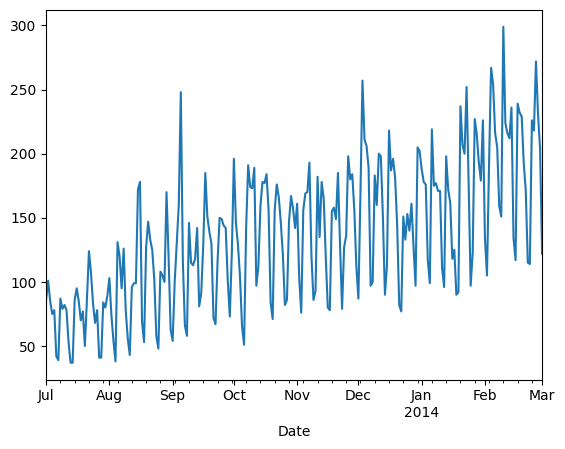

In [33]:
# df["2013-7-1":"2014-3-1"]["count"].plot()
df[pd.to_datetime("2013-7-1"):pd.to_datetime("2014-3-1")]["count"].plot()
plt.show()

In [34]:
# Timezone
df.index.tz is None

True

In [48]:
df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')
df.index.tz

<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>

In [49]:
df.index = df.index.tz_convert(None)
df.index.tz is None

True

In [10]:
import zipfile
zip_path = '../Datasets/time_series_data/train_data_complete.zip'
csv_filename_in_zip = 'train_data_complete.csv'

with zipfile.ZipFile(zip_path, 'r') as z:
    # Read the CSV file from the zip archive
    with z.open(csv_filename_in_zip) as f:
        df2 = pl.read_csv(f)
        df2.shape

Polars found a filename. Ensure you pass a path to the file instead of a python file object when possible for best performance.


In [11]:
df2.head()

Date,count
str,i64
"""2012-08-25""",3
"""2012-08-26""",3
"""2012-08-27""",2
"""2012-08-28""",2
"""2012-08-29""",2


In [8]:
df2.dtypes

[Utf8, Int64]

In [9]:
# convert polars dataframe column Date to datetime
df2 = df2.with_columns(pl.col("Date").str.to_datetime(time_zone="UTC"))
df2.dtypes

[Datetime(time_unit='us', time_zone='UTC'), Int64]

In [10]:
df2.head()

Date,count
"datetime[μs, UTC]",i64
2012-08-25 00:00:00 UTC,3
2012-08-26 00:00:00 UTC,3
2012-08-27 00:00:00 UTC,2
2012-08-28 00:00:00 UTC,2
2012-08-29 00:00:00 UTC,2


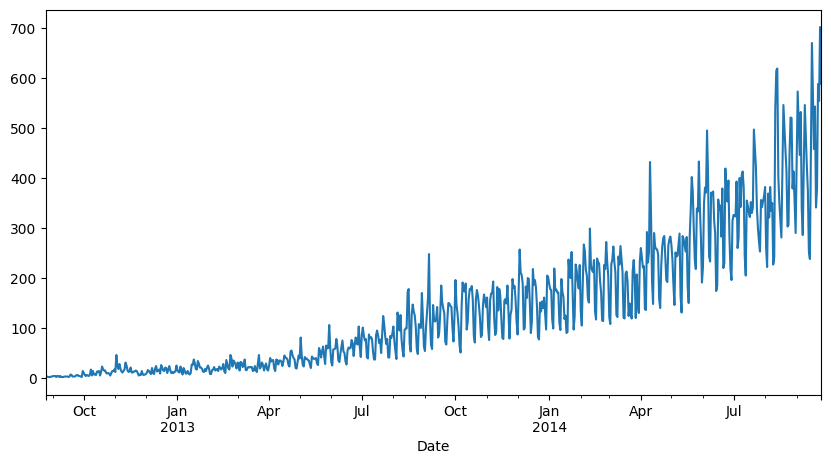

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

df2.to_pandas().set_index('Date')["count"].plot(ax=ax)
plt.show()

### Hold Out Validation

In [12]:
train_size = int(len(df2) * 0.8)
train_df = df2.slice(0, train_size).to_pandas()
test_df = df2.slice(train_size, len(df2)).to_pandas()

In [11]:
train_df.shape, test_df.shape

((609, 2), (153, 2))

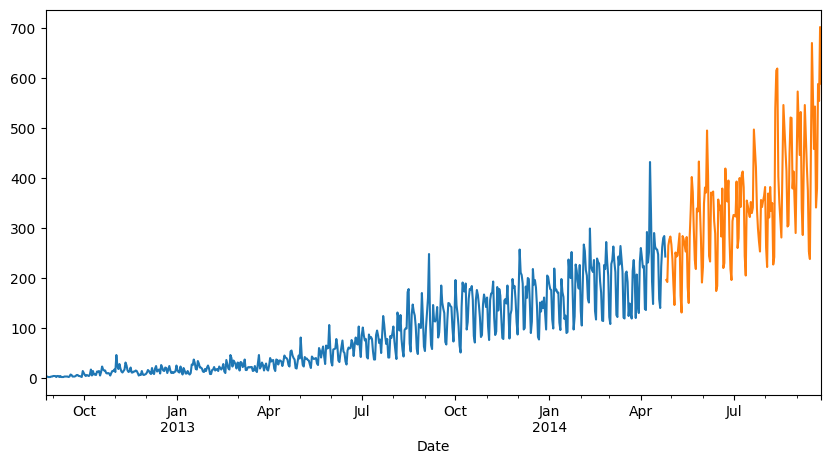

In [84]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df.set_index('Date')["count"].plot(ax=ax)
test_df.set_index('Date')["count"].plot(ax=ax)
plt.show()

### Cross Validation

In [14]:
############################################################################################################
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


TRAIN: 0 126 TEST: 127 253
TRAIN: 0 253 TEST: 254 380
TRAIN: 0 380 TEST: 381 507
TRAIN: 0 507 TEST: 508 634
TRAIN: 0 634 TEST: 635 761


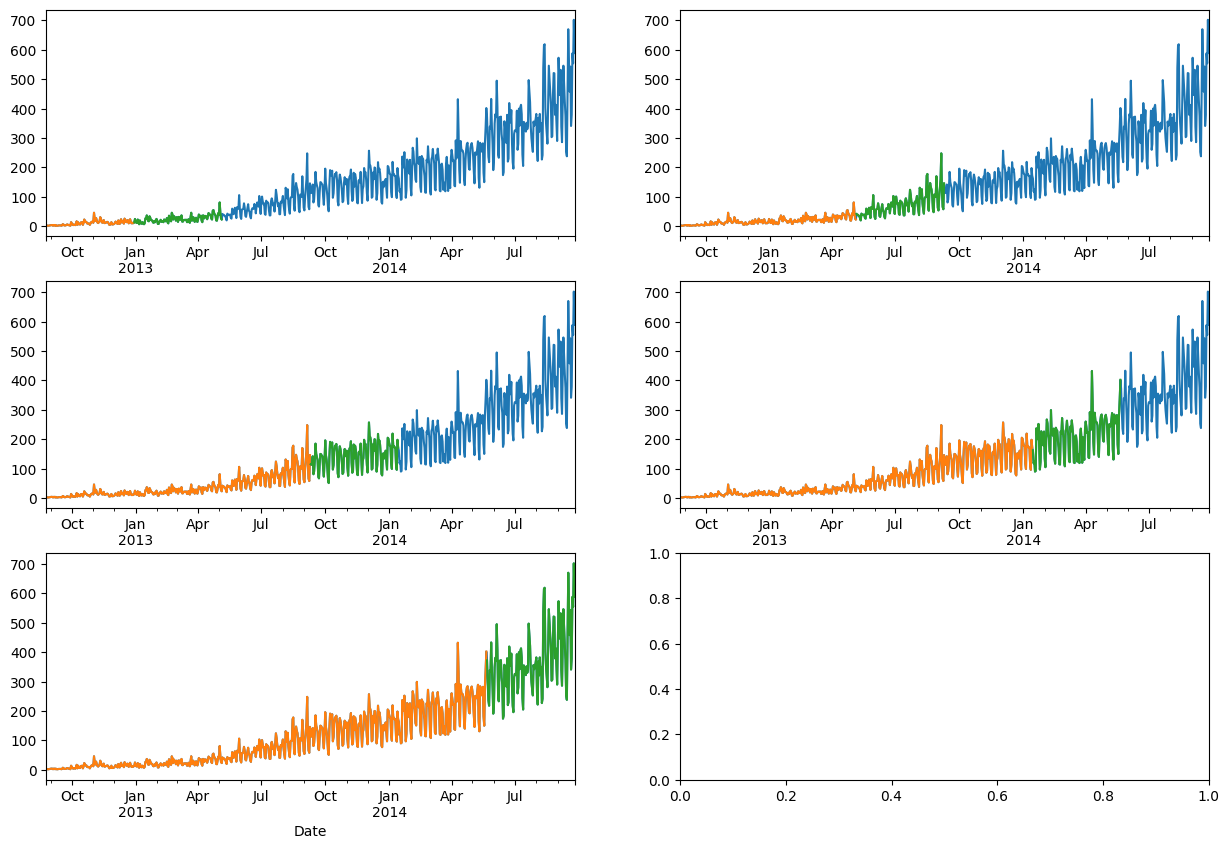

In [100]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.flatten()
i = 0
for train_index, test_index in tscv.split(df2):
    print("TRAIN:", train_index[0], train_index[-1], "TEST:", test_index[0], test_index[-1])
    X_train, X_test = df2[train_index], df2[test_index]

    df2.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    X_train.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    X_test.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    i += 1
plt.show()

### Walk Forward Validation

TRAIN: 0 0 TEST: 127 127
TRAIN: 0 127 TEST: 254 254
TRAIN: 0 254 TEST: 381 381
TRAIN: 0 381 TEST: 508 508
TRAIN: 0 508 TEST: 635 635


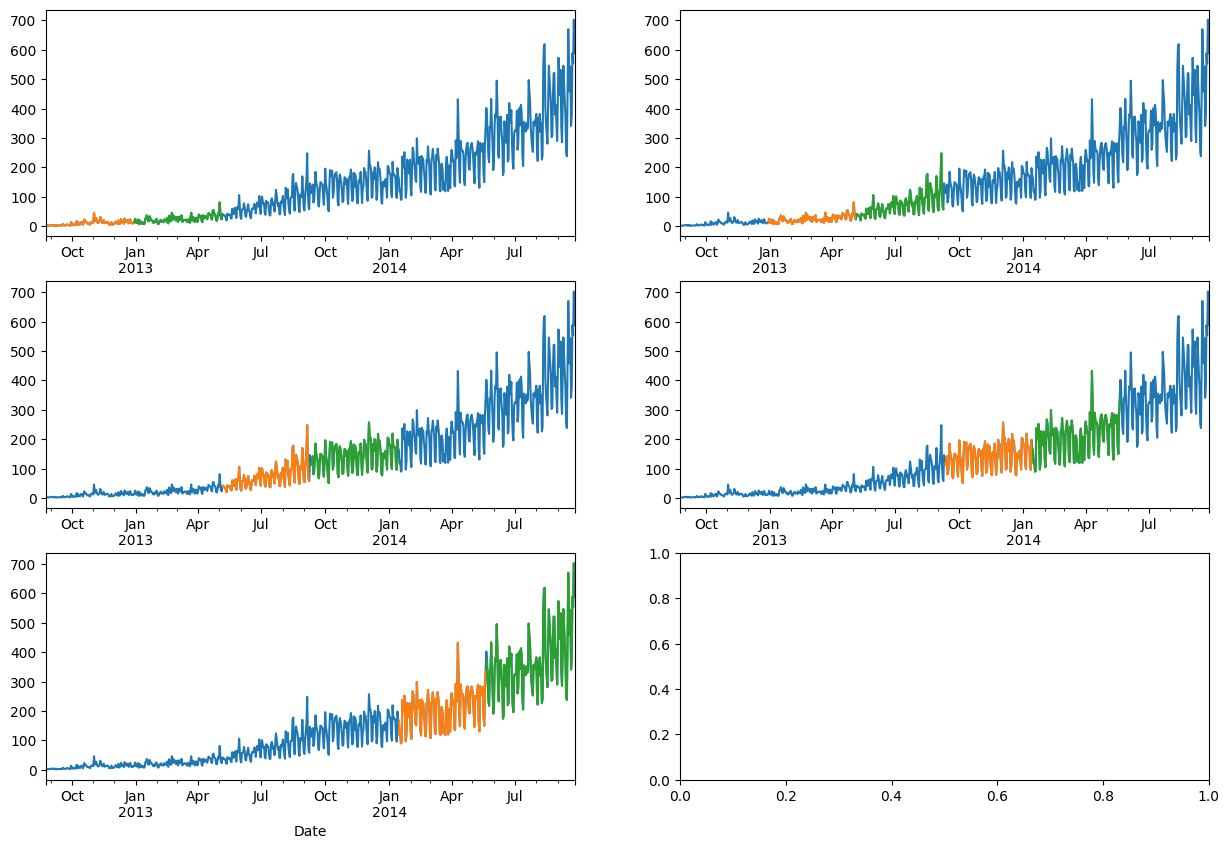

In [104]:
# walk forward validation
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax = ax.flatten()
i = 0

for train_index, test_index in tscv.split(df2):
    print("TRAIN:", train_index[0], train_index[-1]-126, "TEST:", test_index[0], test_index[-1]-126)
    X_train, X_test = df2[train_index[-1]-126: train_index[-1]], df2[test_index[-1]-126: test_index[-1]]

    df2.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    X_train.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    X_test.to_pandas().set_index('Date')["count"].plot(ax=ax[i])
    i += 1
plt.show()

### Feature Engineering

In [105]:
df2.head()

Date,count
"datetime[μs, UTC]",i64
2012-08-25 00:00:00 UTC,3
2012-08-26 00:00:00 UTC,3
2012-08-27 00:00:00 UTC,2
2012-08-28 00:00:00 UTC,2
2012-08-29 00:00:00 UTC,2


In [106]:
df2["Date"].min(), df2["Date"].max()

(datetime.datetime(2012, 8, 25, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
 datetime.datetime(2014, 9, 25, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))

In [107]:
df2["Date"].max() - df2["Date"].min()

datetime.timedelta(days=761)

In [18]:
df2.shape

(762, 2)

In [19]:
df2 = df2.with_columns(
    pl.col("Date").dt.year().alias("year"),
    pl.col("Date").dt.month().alias("month"),
    pl.col("Date").dt.day().alias("day"),
    pl.col("Date").dt.quarter().alias("quarter"),
    pl.col("Date").dt.weekday().alias("weekday")
)
df2.head()

Date,count,year,month,day,quarter,weekday
"datetime[μs, UTC]",i64,i32,u32,u32,u32,u32
2012-08-25 00:00:00 UTC,3,2012,8,25,3,6
2012-08-26 00:00:00 UTC,3,2012,8,26,3,7
2012-08-27 00:00:00 UTC,2,2012,8,27,3,1
2012-08-28 00:00:00 UTC,2,2012,8,28,3,2
2012-08-29 00:00:00 UTC,2,2012,8,29,3,3


### Modeling

#### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

X = df2.drop(["Date", "count"])
y = df2["count"]

tscv = TimeSeriesSplit(n_splits=5)

# Using walk forward validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index[-1]-126: train_index[-1]], X[test_index[-1]-126: test_index[-1]]
    y_train, y_test = y[train_index[-1]-126: train_index[-1]], y[test_index[-1]-126: test_index[-1]]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"RMSE: {rmse(y_test, y_pred)}")

RMSE: 44.135642717586876
RMSE: 39.54896346486762
RMSE: 78.07827934857342
RMSE: 49.38117022711356
RMSE: 121.02832489253188


#### Simple Moving Average

In [21]:
train_df = df2.to_pandas().iloc[:train_size]
test_df = df2.to_pandas().iloc[train_size:]

train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [22]:
train_df.shape

(609, 6)

In [23]:
train_df.tail(7)

,count,year,month,day,quarter,weekday
Date,,,,,,
2014-04-19 00:00:00+00:00,158,2014,4,19,2,6
2014-04-20 00:00:00+00:00,140,2014,4,20,2,7
2014-04-21 00:00:00+00:00,223,2014,4,21,2,1
2014-04-22 00:00:00+00:00,262,2014,4,22,2,2
2014-04-23 00:00:00+00:00,280,2014,4,23,2,3
2014-04-24 00:00:00+00:00,284,2014,4,24,2,4
2014-04-25 00:00:00+00:00,243,2014,4,25,2,5


In [24]:
# Implementing simple moving average
test_df['moving_avg'] = 0
# 7  week values from train_df
week_value = train_df["count"][-7:]
# print(week_value)
for i in range(0, len(test_df)):
    test_df['moving_avg'][i] = week_value.mean()
    week_value = week_value.shift(-1)
    # print(week_value)
    week_value[-1] = test_df['moving_avg'][i]
    

/tmp/ipykernel_5558/2302836450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['moving_avg'][i] = week_value.mean()


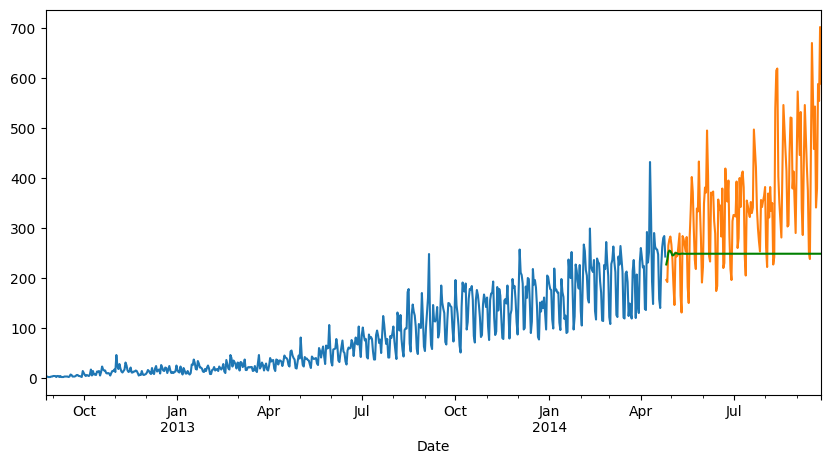

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
train_df["count"].plot(ax=ax,)
test_df["count"].plot(ax=ax, )
test_df["moving_avg"].plot(ax=ax, color="green")
plt.show()

#### Weighted Moving Average

- We can extend simple moving average to weighted moving average by assigning weights to each time step.

In [12]:
train_df = df2.to_pandas().iloc[:train_size]
test_df = df2.to_pandas().iloc[train_size:]

train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [13]:
train_df.shape, test_df.shape

((609, 1), (153, 1))

In [17]:
# Implementing simple moving average
test_df['moving_avg'] = 0
# 7  week values from train_df
week_value = train_df["count"][-7:]
# weights
weights = np.arange(1, 8)/np.arange(1, 8).sum()
# print(week_value)
for i in range(0, len(test_df)):
    test_df['moving_avg'][i] = (week_value * weights).sum()
    week_value = week_value.shift(-1)
    # print(week_value)
    week_value[-1] = test_df['moving_avg'][i]
    

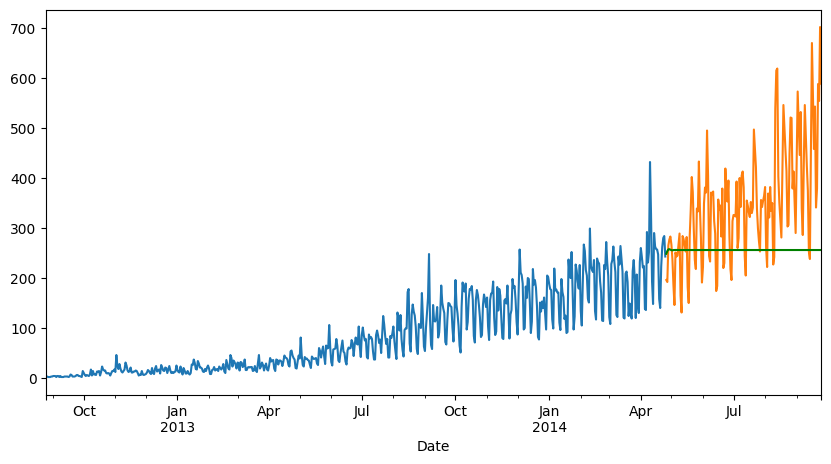

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
train_df["count"].plot(ax=ax,)
test_df["count"].plot(ax=ax, )
test_df["moving_avg"].plot(ax=ax, color="green")
plt.show()

#### Simple Exponential Moving Average (Exponential Smoothing)

- Exponential moving average is a weighted moving average that assigns exponentially decreasing weights to the time steps.

$$EMA(t) = (1 - alpha) * EMA(t-1) + alpha * x(t)$$

In [48]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [49]:
train_df = df2.to_pandas().iloc[:train_size]
test_df = df2.to_pandas().iloc[train_size:]

train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [53]:
model = SimpleExpSmoothing(train_df["count"])
model = model.fit(smoothing_level=0.7)
test_df['simple_exp_smoothing'] = model.forecast(len(test_df))

/home/rishabh/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/rishabh/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


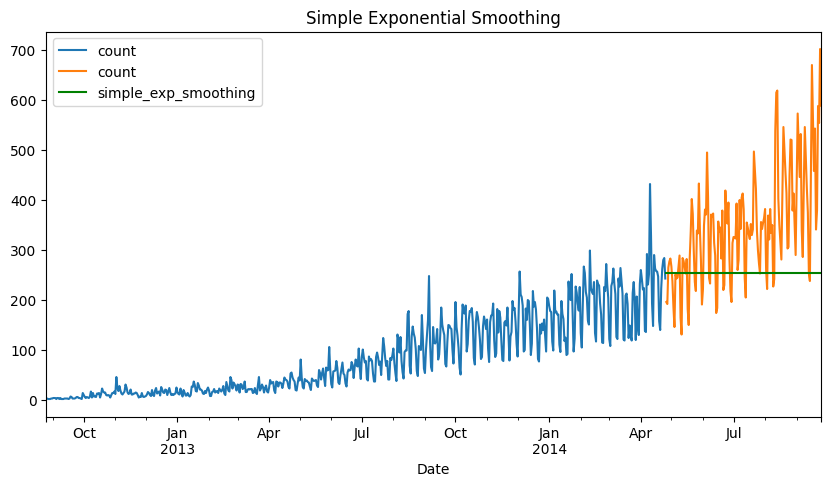

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["simple_exp_smoothing"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Simple Exponential Smoothing")
plt.show()

In [55]:
test_df.head()

,count,year,month,day,quarter,weekday,simple_exp_smoothing
Date,,,,,,,
2014-04-26 00:00:00+00:00,196,2014,4,26,2,6,253.969688
2014-04-27 00:00:00+00:00,192,2014,4,27,2,7,253.969688
2014-04-28 00:00:00+00:00,265,2014,4,28,2,1,253.969688
2014-04-29 00:00:00+00:00,277,2014,4,29,2,2,253.969688
2014-04-30 00:00:00+00:00,283,2014,4,30,2,3,253.969688


In [68]:
# RMSE
rmse(test_df["count"], test_df["simple_exp_smoothing"])

146.07890444359646

#### Time Series Components

- Trend
    Trend is the long term increase or decrease in the data.

- Seasonality
    Seasonality is the repeating short term cycle in the data.

- Residual
    Residual is the random noise in the data.

#### Decomposition

- Decomposition is the process of separating the time series data into its components.

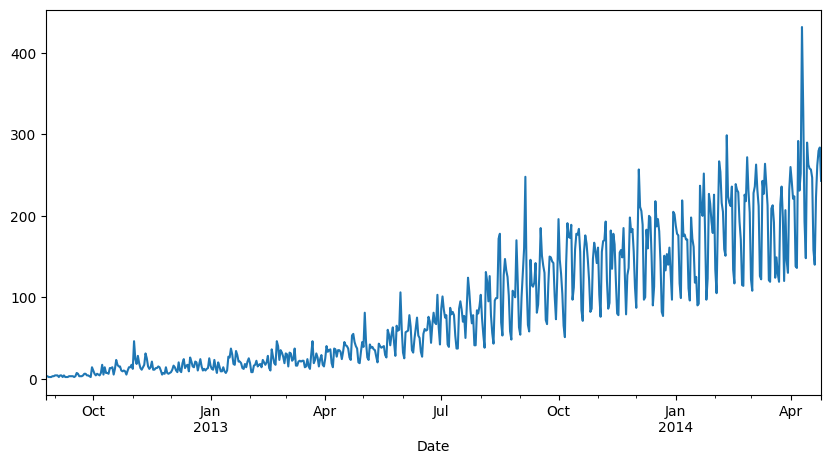

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
train_df["count"].plot()
plt.show()

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

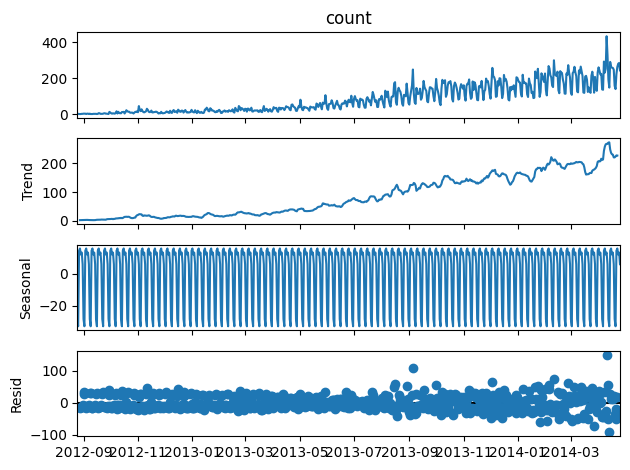

In [62]:
decomposed_series = seasonal_decompose(train_df["count"])
decomposed_series.plot()
plt.show()

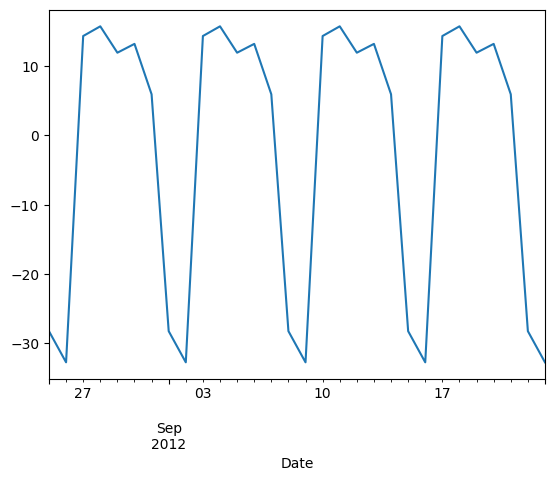

In [67]:
decomposed_series.seasonal[:30].plot()
plt.show()

- We have a weekly seasonality in the data.
- We can clearly see the trend, seasonality and residual components in the data.

#### Double Exponential Smoothing (Holt's Linear Trend Method)

- Double exponential smoothing is used to forecast time series data with a trend.

- Level

$$l(t) = alpha * x(t) + (1 - alpha) * (l(t-1) + b(t-1))$$

- Trend

$$b(t) = beta * (l(t) - l(t-1)) + (1 - beta) * b(t-1)$$

- Forecast

$$F(t+h) = l(t) + h * b(t)$$

$$h = 1, 2, 3, ...$$

In [69]:
from statsmodels.tsa.api import ExponentialSmoothing

In [97]:
model = ExponentialSmoothing(train_df["count"], trend="add")
model = model.fit(smoothing_level=0.5, smoothing_slope=0.02)

test_df['exp_smoothing'] = model.forecast(len(test_df))

/home/rishabh/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_5558/2220978914.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = model.fit(smoothing_level=0.5, smoothing_slope=0.02)


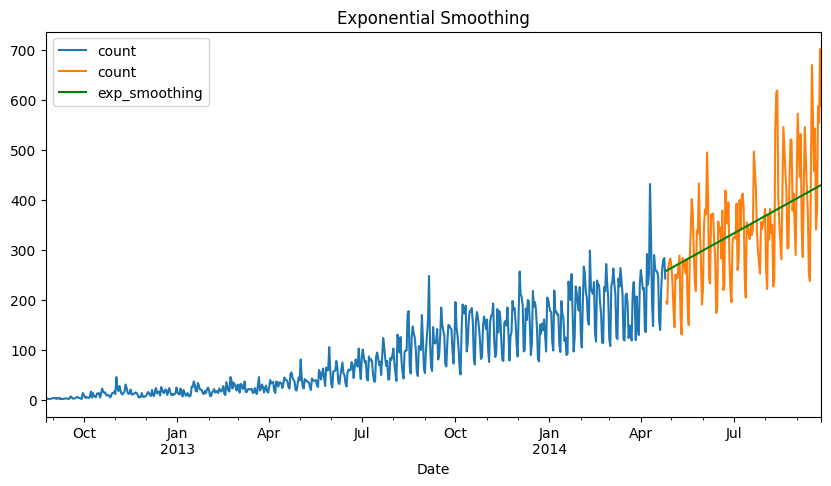

In [98]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["exp_smoothing"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Exponential Smoothing")
plt.show()

In [99]:
model.params

{'smoothing_level': 0.5,
 'smoothing_trend': 0.02,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2.532501164535098,
 'initial_trend': 0.12177697820588601,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [100]:
# RMSE
rmse(test_df["count"], test_df["exp_smoothing"])

89.82385951092634

#### Triple Exponential Smoothing (Holt-Winters Method)

- Triple exponential smoothing is used to forecast time series data with a trend and seasonality.

- Level

$$l(t) = alpha * (x(t) - s(t-L)) + (1 - alpha) * (l(t-1) + b(t-1))$$

- Trend

$$b(t) = beta * (l(t) - l(t-1)) + (1 - beta) * b(t-1)$$

- Seasonality

$$s(t) = gamma * (x(t) - l(t)) + (1 - gamma) * s(t-L)$$

$$L = seasonality component (1-day, 7-week, 30-month, 365-year)$$

- Forecast

$$F(t+h) = l(t) + h * b(t) + s(t-L+h)$$

$$h = 1, 2, 3, ...$$

In [107]:
from statsmodels.tsa.api import ExponentialSmoothing

In [115]:
model = ExponentialSmoothing(train_df["count"], trend="add", seasonal="add", seasonal_periods=7)
model = model.fit(smoothing_level=0.5, smoothing_slope=0.02, damping_slope=0.98)
test_df['holt'] = model.forecast(len(test_df))

/home/rishabh/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_5558/1887878203.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model = model.fit(smoothing_level=0.5, smoothing_slope=0.02, damping_slope=0.98)
/home/rishabh/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:211: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead.
  return func(*args, **kwargs)


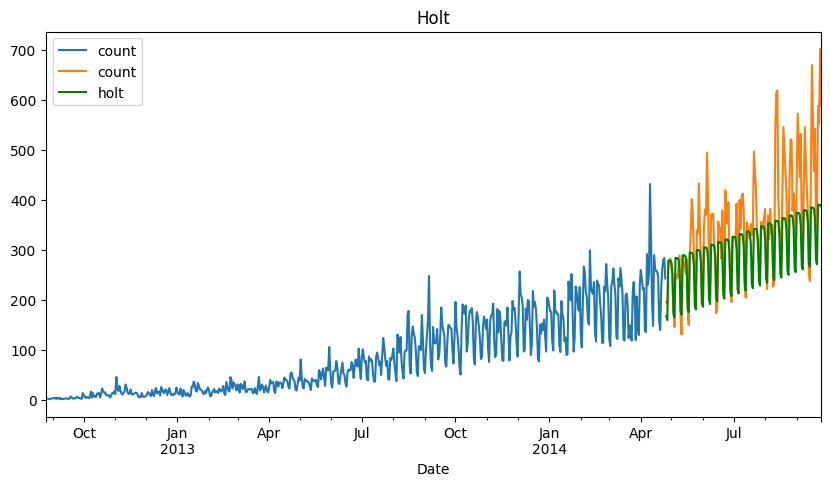

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["holt"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Holt")
plt.show()

In [114]:
# RMSE
rmse(test_df["count"], test_df["holt"])

85.97382093452246

In [120]:
# Tuning the Holt-Winters model
import itertools

param_grid = {
    "smoothing_level": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "smoothing_slope": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    "damping_slope": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    "seasonal_periods": [6,7,8]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["smoothing_level"],
    param_grid["smoothing_slope"],
    param_grid["damping_slope"],
    param_grid["seasonal_periods"]
))

best_score = float("inf")
best_params = None

print(f"Total Combinations: {len(param_combinations)}")

Total Combinations: 1029


In [125]:
for i, params in tqdm.tqdm_notebook(enumerate(param_combinations)):
    smoothing_level, smoothing_slope, damping_slope, seasonal_periods = params
    model = ExponentialSmoothing(train_df["count"], trend="add", seasonal="add", seasonal_periods=seasonal_periods)
    model = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope=damping_slope)

    y_pred = model.forecast(len(test_df))
    score = rmse(test_df["count"], y_pred)

    if score < best_score:
        best_score = score
        best_params = params
    if i % 100 == 0:
        print(f"{i+1}/{len(param_combinations)} | RMSE: {score} | Best RMSE: {best_score}")

print(f"Best RMSE: {best_score} | Best Params: {best_params}")
print(f"Best Params: {best_params}")

0it [00:00, ?it/s]

1/1029 | RMSE: 101.3632906115898 | Best RMSE: 91.85988183886913
101/1029 | RMSE: 92.49452123910913 | Best RMSE: 88.6466406020984
201/1029 | RMSE: 88.80742900605382 | Best RMSE: 85.60669937779102
301/1029 | RMSE: 97.46137618431506 | Best RMSE: 62.047206258267224
401/1029 | RMSE: 82.11081022569142 | Best RMSE: 62.047206258267224
501/1029 | RMSE: 88.82987165391455 | Best RMSE: 62.047206258267224
601/1029 | RMSE: 99.00616201671832 | Best RMSE: 62.047206258267224
701/1029 | RMSE: 63.317143479376604 | Best RMSE: 62.047206258267224
801/1029 | RMSE: 88.56251056662468 | Best RMSE: 62.047206258267224
901/1029 | RMSE: 104.03308437889308 | Best RMSE: 62.047206258267224
1001/1029 | RMSE: 66.97814101699532 | Best RMSE: 62.047206258267224
Best RMSE: 62.047206258267224 | Best Params: (0.4, 0.2, 0.01, 7)
Best Params: (0.4, 0.2, 0.01, 7)


In [126]:
best_model = ExponentialSmoothing(train_df["count"], trend="add", seasonal="add", seasonal_periods=best_params[3])
best_model = best_model.fit(smoothing_level=best_params[0], smoothing_slope=best_params[1], damping_slope=best_params[2])
test_df['holt'] = best_model.forecast(len(test_df))

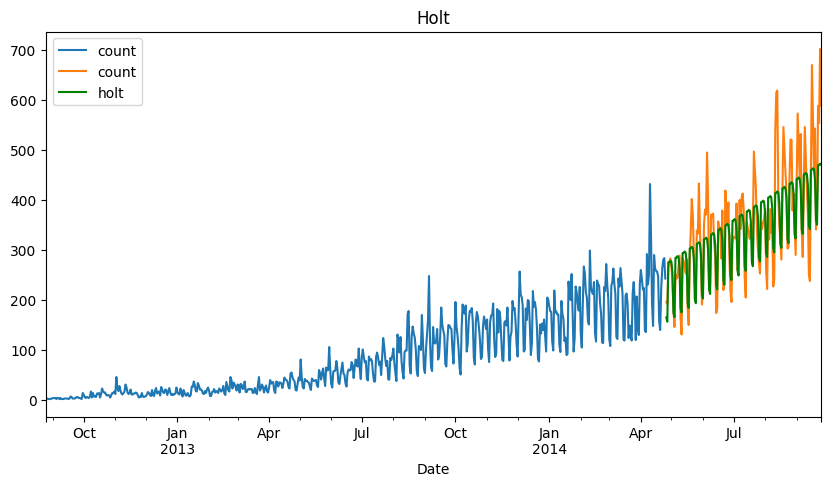

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["holt"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Holt")
plt.show()

In [128]:
#RMSE
rmse(test_df["count"], test_df["holt"])

62.047206258267224

#### ARIMA (AutoRegressive Integrated Moving Average)

- ARIMA is a popular statistical method for time series forecasting.

- ARIMA model has 3 components: AR (AutoRegressive), I (Integrated), MA (Moving Average).

- AR (AutoRegressive) is a model that uses the dependent relationship between an observation and some number of lagged observations.

- I (Integrated) is a model that uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

- MA (Moving Average) is a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

- ARIMA model is defined by 3 parameters: p, d, q.

- p is the number of lag observations included in the model (lag order).

- d is the number of times that the raw observations are differenced (degree of differencing).

- q is the size of the moving average window (order of moving average).


##### Stationarity

- A stationary time series is one whose properties do not depend on the time at which the series is observed.

    - **Strict Stationary**: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are constant over time.

    - **Trend Stationary**: A series that has no unit root but exhibit a trend is referred to as trend stationary.

##### Tests for Stationarity
- Visual Test


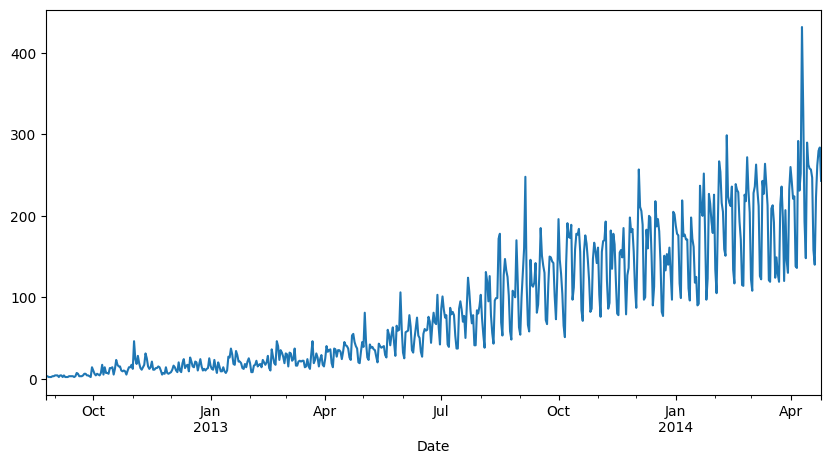

In [134]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
plt.show()

- Statistical Test
    - Augmented Dickey-Fuller (ADF) Test
        - Null Hypothesis (H0): The time series is non-stationary.
        - Alternate Hypothesis (H1): The time series is stationary.

    - Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
        - Null Hypothesis (H0): The time series is trend stationary.
        - Alternate Hypothesis (H1): The time series is non-stationary.

In [136]:
# ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_df["count"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.088170
p-value: 0.965244
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [137]:
# KPSS Test
from statsmodels.tsa.stattools import kpss

result = kpss(train_df["count"])
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 3.737697
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


##### Making the series stationary

- Differencing
    - Differencing is a method of transforming a time series dataset.
    - It calculates the difference between each data point and the one that preceded it.
    - Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

$$x(t) = x(t) - x(t-1)$$

- Seasonal Differencing
    - Seasonal differencing is the difference between an observation and the corresponding observation in the previous season.

$$x(t) = x(t) - x(t-L)$$
$$L = seasonality component (1-day, 7-week, 30-month, 365-year)$$

- Log Transformation
    - Log transformation can help stabilize the variance of a time series.
    - Log transformation can help make a time series more stationary.

$$x(t) = log(x(t))$$

- Box-Cox Transformation
    - Box-Cox transformation is a family of power transformations defined by a parameter lambda.
    - Box-Cox transformation can help stabilize the variance of a time series.

$$
x(t) = 
\begin{cases} 
\frac{x(t)^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\log(x(t)) & \text{if } \lambda = 0 
\end{cases}
$$

- Differencing

In [140]:
# Differencing
train_df["count_diff"] = train_df["count"].diff()
train_df.head()

,count,year,month,day,quarter,weekday,count_diff
Date,,,,,,,
2012-08-25 00:00:00+00:00,3,2012,8,25,3,6,NaN
2012-08-26 00:00:00+00:00,3,2012,8,26,3,7,0.0
2012-08-27 00:00:00+00:00,2,2012,8,27,3,1,-1.0
2012-08-28 00:00:00+00:00,2,2012,8,28,3,2,0.0
2012-08-29 00:00:00+00:00,2,2012,8,29,3,3,0.0


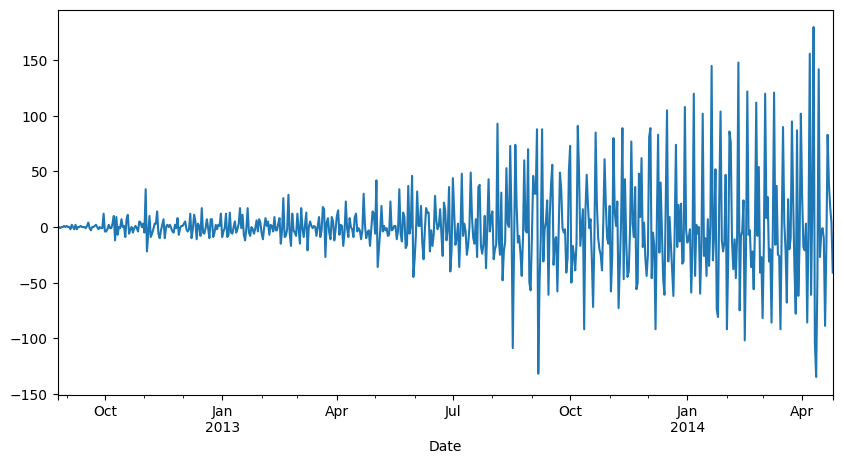

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count_diff"].plot(ax=ax)
plt.show()

- Log Transformation

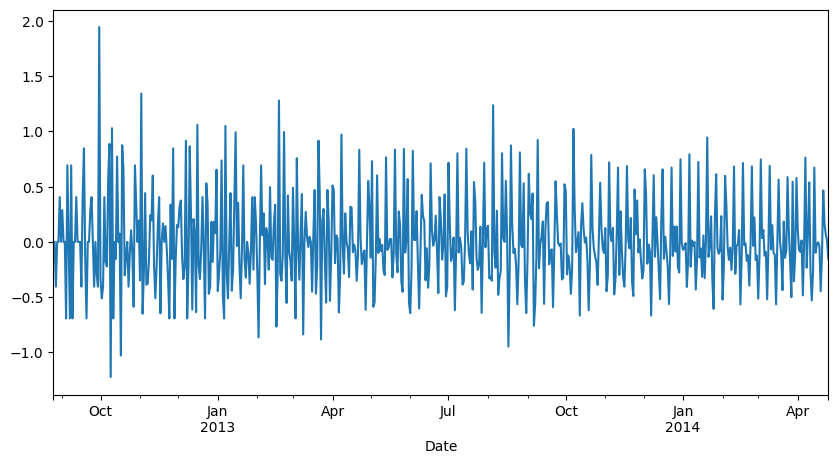

In [171]:
# Log Transformation
train_df["count_log"] = np.log(train_df["count"])
train_df["count_diff_log"] = train_df["count_log"].diff()

fig, ax = plt.subplots(figsize=(10, 5))
train_df["count_diff_log"].plot(ax=ax)
plt.show()

In [172]:
def check_adf(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [173]:
def check_kpss(df):
    result = kpss(df)
    print('KPSS Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t%s: %.3f' % (key, value))

In [174]:
check_adf(train_df["count_diff_log"].dropna())
check_kpss(train_df["count_diff_log"].dropna())

ADF Statistic: -7.754086
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.866
	10%: -2.569
KPSS Statistic: 0.147507
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


- Box-Cox Transformation

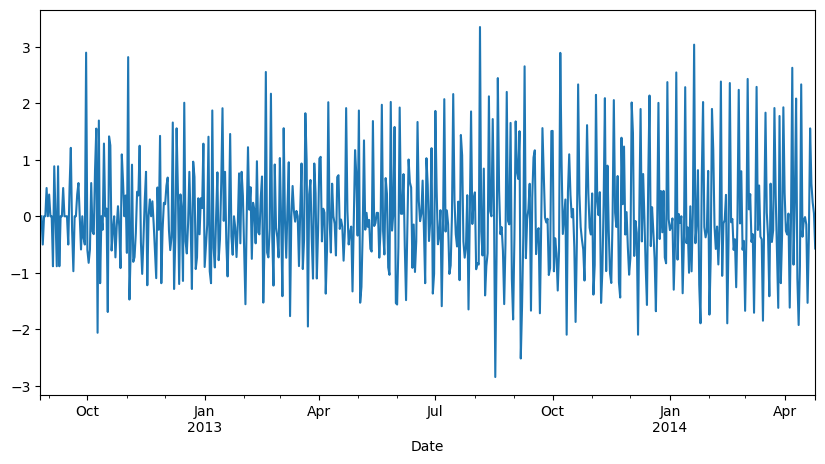

In [148]:
# Box-Cox Transformation
from scipy.stats import boxcox

train_df["count_boxcox"], lam = boxcox(train_df["count"])
train_df["count_diff_boxcox"] = train_df["count_boxcox"].diff()

fig, ax = plt.subplots(figsize=(10, 5))
train_df["count_diff_boxcox"].plot(ax=ax)
plt.show()

##### ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function)

- Correlation
    - Correlation is a statistical measure that describes the strength of the relationship between two variables.

- ACF (AutoCorrelation Function) is a measure of the correlation between the time series and a lagged version of itself.

- PACF (Partial AutoCorrelation Function) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

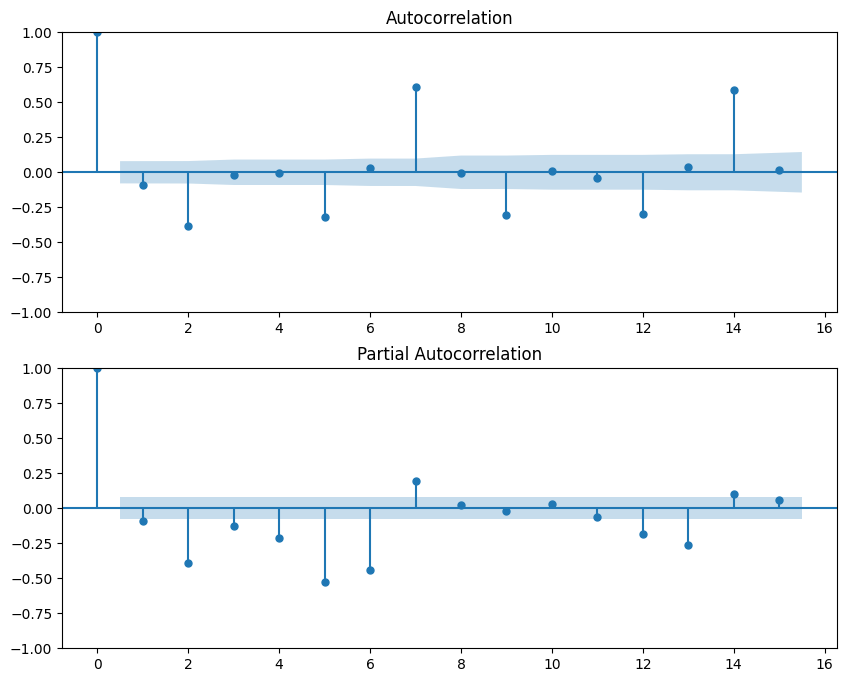

In [151]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_df["count_diff_boxcox"].dropna(), ax=ax[0], lags=15)
plot_pacf(train_df["count_diff_boxcox"].dropna(), ax=ax[1], lags=15)
plt.show()

- From ACF and PACF plots, we can determine the values of p, d, q for ARIMA model.

- p => 2

- q => 2

- d => 1 (1 order differencing is required to make the series stationary)

##### ARIMA Model

In [156]:
from statsmodels.tsa.arima.model import ARIMA

In [188]:
model = ARIMA(train_df["count_log"], order=(2, 1, 2), trend="t")
model = model.fit()
test_df['arima'] = np.exp(model.forecast(len(test_df)))

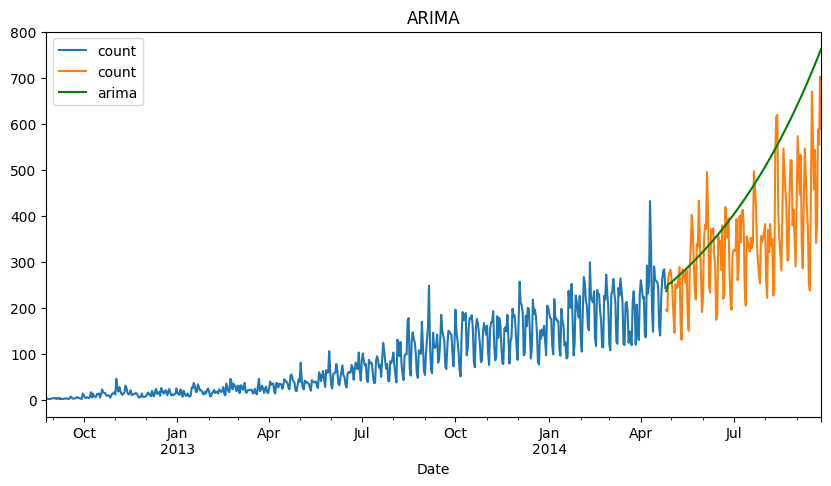

In [189]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["arima"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("ARIMA")
plt.show()

In [190]:
# RMSE
rmse(test_df["count"], test_df["arima"])

159.8629468637958

#### SARIMA (Seasonal AutoRegressive Integrated Moving Average)

- SARIMA is an extension of ARIMA that explicitly models the seasonal element in univariate time series data.

- SARIMA model is defined by 7 parameters: p, d, q, P, D, Q, m.

- p is the number of lag observations included in the model (lag order).

- d is the number of times that the raw observations are differenced (degree of differencing).

- q is the size of the moving average window (order of moving average).

- P is the number of seasonal lag observations included in the model (lag order).

- D is the number of times that the seasonal observations are differenced (degree of seasonal differencing).

- Q is the size of the seasonal moving average window (order of seasonal moving average).

- m is the number of time steps for a single seasonal period.

- Seasonal Differencing

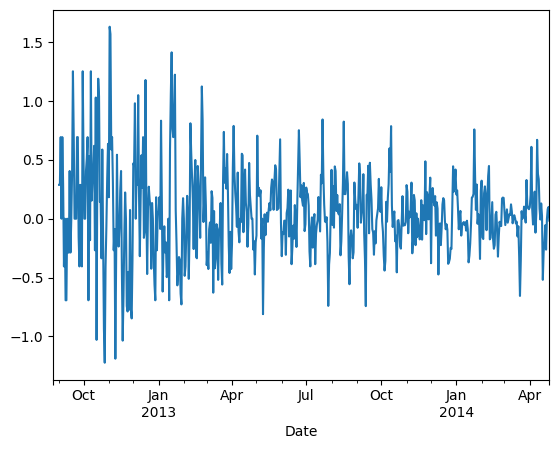

In [192]:
train_df["count_log"] = np.log(train_df["count"])
train_df["count_log_seas_diff"] = train_df["count_log"].diff(7)
train_df["count_log_seas_diff"].plot()
plt.show()

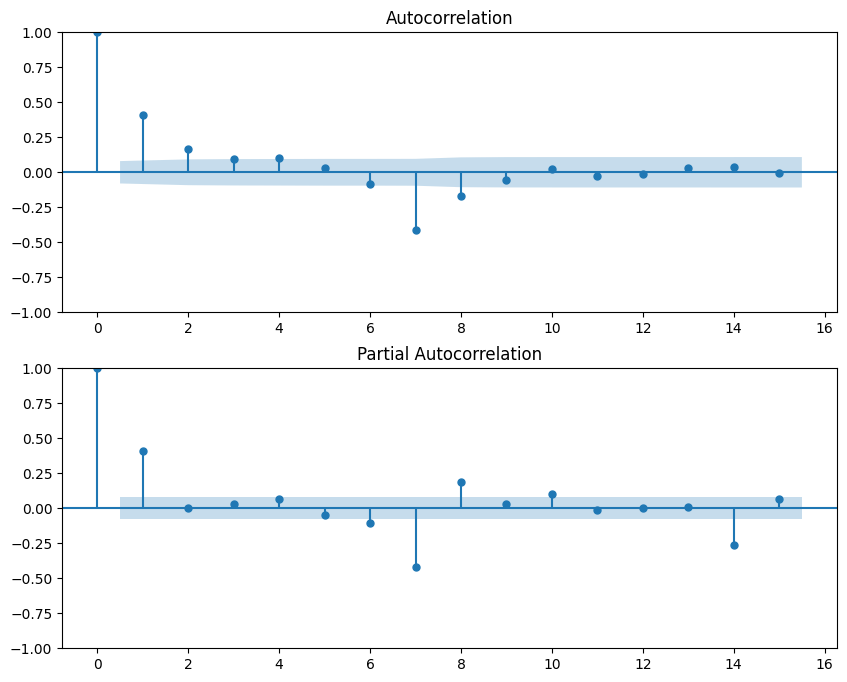

In [193]:
# ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(train_df["count_log_seas_diff"].dropna(), ax=ax[0], lags=15)
plot_pacf(train_df["count_log_seas_diff"].dropna(), ax=ax[1], lags=15)
plt.show()

In [216]:
# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [215]:
model = SARIMAX(train_df["count_log"], order=(2, 1, 2), seasonal_order=(1, 1, 1, 7))
model = model.fit()
test_df['sarima'] = np.exp(model.forecast(len(test_df)))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64885D+00    |proj g|=  6.93199D+00



At iterate    5    f=  3.55297D-01    |proj g|=  2.30393D-01

At iterate   10    f=  1.30155D-01    |proj g|=  3.80687D-01

At iterate   15    f=  1.20146D-01    |proj g|=  6.22775D-03

At iterate   20    f=  1.19636D-01    |proj g|=  1.37846D-02

At iterate   25    f=  1.19267D-01    |proj g|=  5.14750D-04

At iterate   30    f=  1.19121D-01    |proj g|=  1.15457D-02

At iterate   35    f=  1.17951D-01    |proj g|=  1.14619D-02

At iterate   40    f=  1.17674D-01    |proj g|=  1.28147D-03

At iterate   45    f=  1.17670D-01    |proj g|=  6.29928D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     61   

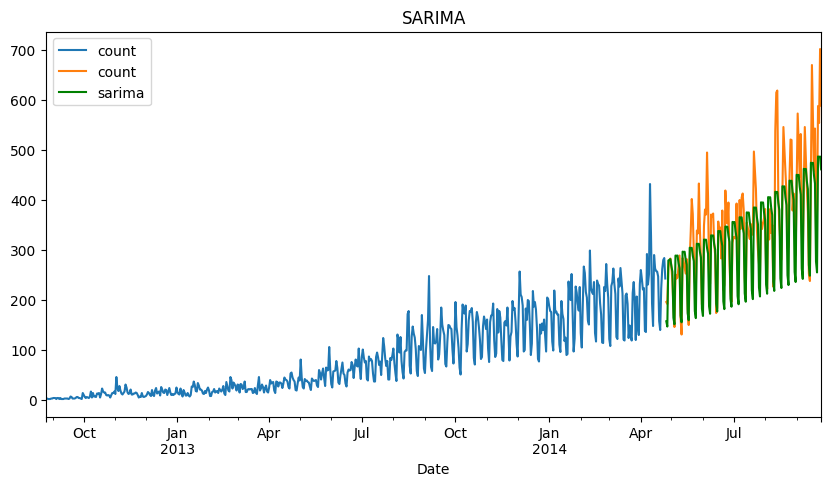

In [217]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df["count"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["sarima"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("SARIMA")
plt.show()

In [218]:
# RMSE
rmse(test_df["count"], test_df["sarima"])

64.52680313549152

#### Prophet

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

- Prophet is open source software released by Facebook's Core Data Science team.

- Prophet decomposes time series data into trend, seasonality and holiday components.

- Prophet uses a generalized additive model (GAM) to model time series data.

- Prophet is designed for analyzing time series that display patterns on different time scales such as yearly, weekly and daily.

In [220]:
# !pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 16.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [221]:
from prophet import Prophet

In [228]:
model = Prophet()
train_df = df2.to_pandas().reset_index()[["Date", "count"]]
train_df["Date"] = train_df["Date"].dt.tz_localize(None)
train_df.columns = ['ds', 'y']
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

test_df['prophet'] = forecast["yhat"].values[-len(test_df):]

22:43:07 - cmdstanpy - INFO - Chain [1] start processing
22:43:08 - cmdstanpy - INFO - Chain [1] done processing


In [230]:
train_df.head()

,ds,y
0,2012-08-25,3
1,2012-08-26,3
2,2012-08-27,2
3,2012-08-28,2
4,2012-08-29,2


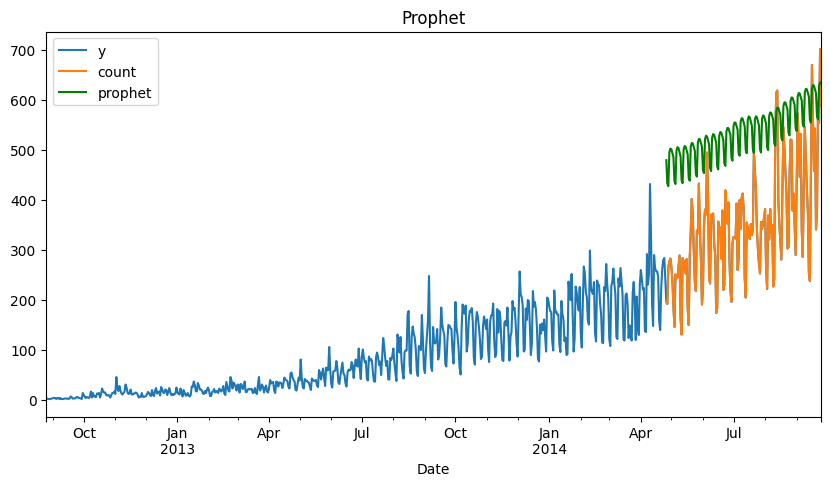

In [232]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df.set_index('ds')["y"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["prophet"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Prophet")
plt.show()

In [235]:
# RMSE
rmse(test_df["count"], test_df["prophet"])

206.92927545755163

In [233]:
# Tune Prophet
param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "holidays_prior_scale": [0.01, 0.1, 1.0, 10.0],
    "seasonality_mode": ["additive", "multiplicative"]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["changepoint_prior_scale"],
    param_grid["seasonality_prior_scale"],
    param_grid["holidays_prior_scale"],
    param_grid["seasonality_mode"]
))

best_score = float("inf")
best_params = None

print(f"Total Combinations: {len(param_combinations)}")

Total Combinations: 128


In [234]:
for i, params in tqdm.tqdm_notebook(enumerate(param_combinations)):
    changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode = params
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_df)

    forecast = model.make_future_dataframe(periods=len(test_df), freq='D')
    forecast = model.predict(forecast)

    y_pred = forecast["yhat"].values[-len(test_df):]
    score = rmse(test_df["count"], y_pred)

    if score < best_score:
        best_score = score
        best_params = params
    if i % 100 == 0:
        print(f"{i+1}/{len(param_combinations)} | RMSE: {score} | Best RMSE: {best_score}")

print(f"Best RMSE: {best_score} | Best Params: {best_params}")

0it [00:00, ?it/s]

22:46:39 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing
22:46:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:46:40 - cmdstanpy - INFO - Chain [1] start processing
22:46:52 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - INFO - Chain [1] start processing


1/128 | RMSE: 107.64078446283699 | Best RMSE: 107.64078446283699


22:46:53 - cmdstanpy - INFO - Chain [1] done processing
22:46:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:46:53 - cmdstanpy - INFO - Chain [1] start processing
22:47:03 - cmdstanpy - INFO - Chain [1] done processing
22:47:04 - cmdstanpy - INFO - Chain [1] start processing
22:47:04 - cmdstanpy - INFO - Chain [1] done processing
22:47:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:47:04 - cmdstanpy - INFO - Chain [1] start processing
22:47:16 - cmdstanpy - INFO - Chain [1] done processing
22:47:17 - cmdstanpy - INFO - Chain [1] start processing
22:47:17 - cmdstanpy - INFO - Chain [1] done processing
22:47:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:47:17 - cmdstanpy - I

101/128 | RMSE: 251.01124778229448 | Best RMSE: 99.69205227125916


22:53:27 - cmdstanpy - INFO - Chain [1] done processing
22:53:27 - cmdstanpy - INFO - Chain [1] start processing
22:53:28 - cmdstanpy - INFO - Chain [1] done processing
22:53:29 - cmdstanpy - INFO - Chain [1] start processing
22:53:29 - cmdstanpy - INFO - Chain [1] done processing
22:53:30 - cmdstanpy - INFO - Chain [1] start processing
22:53:30 - cmdstanpy - INFO - Chain [1] done processing
22:53:31 - cmdstanpy - INFO - Chain [1] start processing
22:53:31 - cmdstanpy - INFO - Chain [1] done processing
22:53:32 - cmdstanpy - INFO - Chain [1] start processing
22:53:32 - cmdstanpy - INFO - Chain [1] done processing
22:53:33 - cmdstanpy - INFO - Chain [1] start processing
22:53:34 - cmdstanpy - INFO - Chain [1] done processing
22:53:35 - cmdstanpy - INFO - Chain [1] start processing
22:53:36 - cmdstanpy - INFO - Chain [1] done processing
22:53:37 - cmdstanpy - INFO - Chain [1] start processing
22:53:38 - cmdstanpy - INFO - Chain [1] done processing
22:53:39 - cmdstanpy - INFO - Chain [1] 

Best RMSE: 99.69205227125916 | Best Params: (0.001, 0.01, 0.01, 'multiplicative')


In [236]:
# Using best params
changepoint_prior_scale, seasonality_prior_scale, holidays_prior_scale, seasonality_mode = best_params
model = Prophet(
    changepoint_prior_scale=changepoint_prior_scale,
    seasonality_prior_scale=seasonality_prior_scale,
    holidays_prior_scale=holidays_prior_scale,
    seasonality_mode=seasonality_mode
)
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

test_df['prophet'] = forecast["yhat"].values[-len(test_df):]

22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:38 - cmdstanpy - INFO - Chain [1] done processing
22:54:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:54:38 - cmdstanpy - INFO - Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing


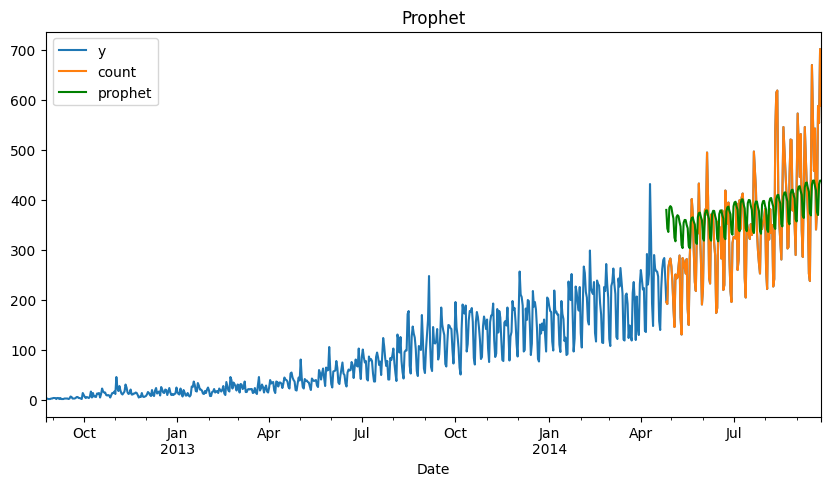

In [237]:
fig, ax = plt.subplots(figsize=(10, 5))

train_df.set_index('ds')["y"].plot(ax=ax)
test_df["count"].plot(ax=ax)
test_df["prophet"].plot(ax=ax, color="green")
plt.legend(loc="best")
plt.title("Prophet")
plt.show()

In [238]:
# RMSE
rmse(test_df["count"], test_df["prophet"])

99.69205227125916